In [559]:
import pandas as pd

df = pd.read_csv("Data_Marketing_Customer_Analysis_Round3.csv")

In [560]:
df['effective_to_date'] = pd.to_datetime(df['effective_to_date'])

C:\Users\Feras\AppData\Local\Temp\ipykernel_18952\3937611957.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['effective_to_date'] = pd.to_datetime(df['effective_to_date'])


In [561]:
num = df.select_dtypes("int64")
cat = df.select_dtypes("object")

## Linear Regression
## 1. X-y split (y is the target variable, in this case, "total claim amount")
## 2. Train-test split.
## 3. Standardize the data (after the data split!).
## 4. Apply linear regression.
## 5. Model Interpretation.

### Using the original numerical dataframe (num) before scaling.
### Defining our independent variables and the dependent variable.

In [562]:
import numpy as np

In [563]:
num_1 = num.drop(columns="total_claim_amount")

In [564]:
X = np.array(num_1)

In [565]:
X

array([[ 4809, 48029,    61, ...,    52,     0,     9],
       [ 2228, 92260,    64, ...,    26,     0,     1],
       [14947, 22139,   100, ...,    31,     0,     2],
       ...,
       [23893, 39837,   201, ...,    63,     0,     2],
       [11971, 64195,   158, ...,    27,     4,     6],
       [ 6857, 68942,   101, ...,     1,     0,     3]], dtype=int64)

In [566]:
y = np.array(num["total_claim_amount"]).reshape(-1,1)

### Splitting the data

In [567]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [568]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 100)

## Scaling the Data
### I will transfrom the indepedent variables and dependent variable since they are not all normally distributed.

In [569]:
from sklearn.preprocessing import PowerTransformer

In [570]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_transformed = pt.transform(X_train)
X_test_transformed = pt.transform(X_test)

In [571]:
pt.fit(y_train)
y_train_transformed = pt.transform(y_train)
y_test_transformed = pt.transform(y_test)

## Performing Linear Regression

In [572]:
lm = LinearRegression()
model = lm.fit(X_train_transformed,y_train_transformed)

In [573]:
print("Slope =", model.coef_)
print("Intercept =", model.intercept_)

Slope = [[-2.08480481e-02 -1.43758190e-01  4.96258343e-01 -9.76148844e-05
  -5.65452562e-03 -2.11877522e-02  1.97560397e-02]]
Intercept = [5.84527671e-12]


## Comparing

In [574]:
y_pred = model.predict(X_test_transformed)

In [575]:
compare = pd.DataFrame({'y_test':list(y_test_transformed) ,'y_pred': list(y_pred)})

In [576]:
compare

,y_test,y_pred
0,[-0.24396624958434066],[-0.5329755038427559]
1,[0.26434240768752915],[0.43784774727757964]
2,[-2.217679240628924],[0.40376159507645215]
3,[-1.3251063471108266],[0.01458986126476162]
4,[1.7008351797377181],[0.9718752095469467]
...,...,...
3202,[0.22065479805990468],[-0.9183327212290082]
3203,[0.2409017326320982],[0.6686653167342379]
3204,[2.2392343647745285],[1.1509166638082813]
3205,[-1.5646410368808357],[-0.8757387844982379]


### Model Evaluation

In [577]:
import matplotlib.pyplot as plt

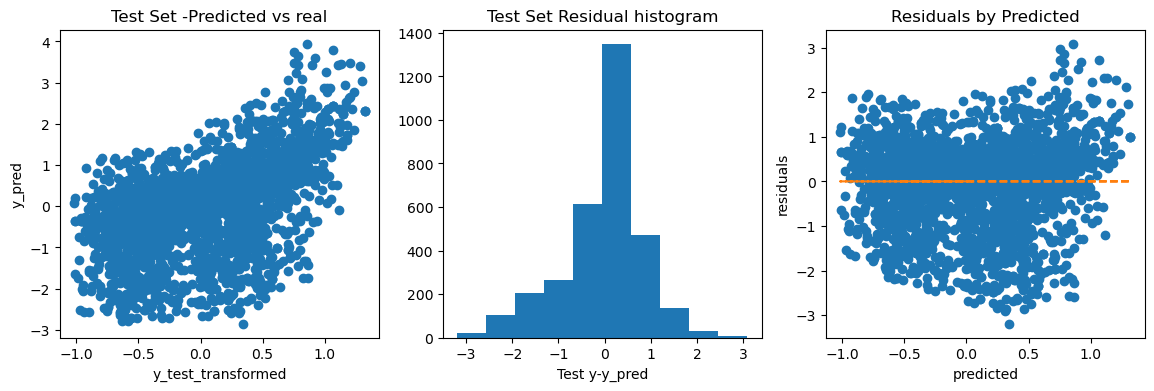

In [578]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test_transformed, 'o')
ax[0].set_xlabel("y_test_transformed")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscedasticity
# Does it resemble a normal distribution?
ax[1].hist(y_test_transformed - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test_transformed - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

# Model Validation

### **1. Model Evaluation:**
- MSE.
- RMSE.
- MAE.
- R2.
- Adjusted R2.

In [579]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
mse = mse(y_test_transformed,y_pred)
print("MSE =",mse)

MSE = 0.7637981044286775


In [580]:
mae = mae(y_test_transformed,y_pred)
print("MAE =",mae)

MAE = 0.6295226660494436


In [581]:
import math

In [582]:
RMSE = math.sqrt(mse)
print("RMSE =",RMSE)

RMSE = 0.8739554361800591


In [583]:
R2 = r2(y_test_transformed,y_pred)
print("R2 =",R2)

R2 = 0.2630439296055753


In [584]:
n = len(y_test_transformed)
k = np.shape(X_test_transformed)[1]

adjusted_R2 = 1 - ((1-R2)*(n-1)/(n-k-1))

In [585]:
print("Adjusted R2 =",adjusted_R2)

Adjusted R2 = 0.26143133426554366


### The adjusted R2 takes into account the number of independent variables the model is trained on. The more the independent variables are, the less the value of the Adjusted R2 will be. Unless a very signifact independent variable is added, the adjusted R2 might increase, however, if we add a lot of independent variable without high signifance, the adjusted R2 will decrease, in other words, penalize us.

### 2. Feature Importance

- Plotting without taking the absolute values of the coefficients

In [586]:
feature = pd.DataFrame({"Column Names":num_1.columns,"Coefficients":model.coef_.reshape(-1)})

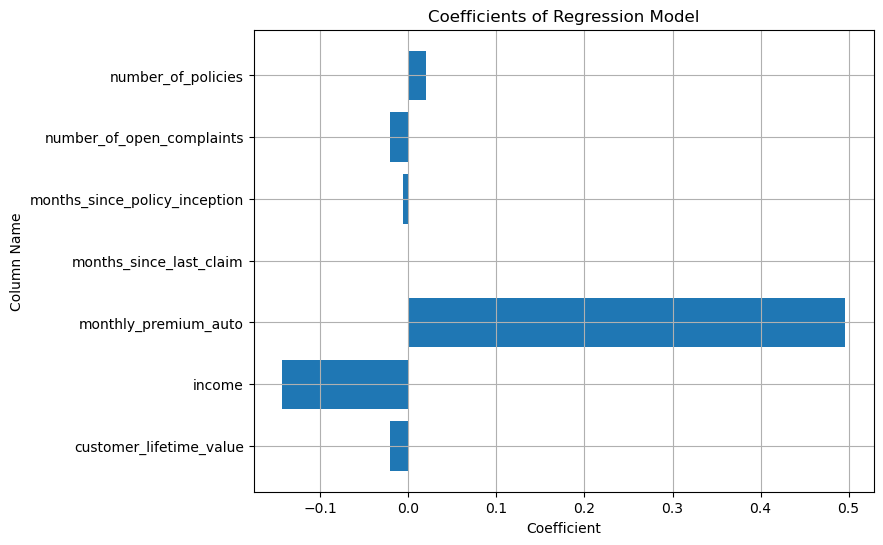

In [587]:
plt.figure(figsize=(8, 6))
plt.barh(feature['Column Names'], feature['Coefficients'])
plt.xlabel('Coefficient')
plt.ylabel('Column Name')
plt.title('Coefficients of Regression Model')
plt.grid(True)
plt.show()

- Plotting with taking the absolute values of the coefficients

In [588]:
feature_1 = pd.DataFrame({"Column Names":num_1.columns,"Coefficients":abs(model.coef_.reshape(-1))})

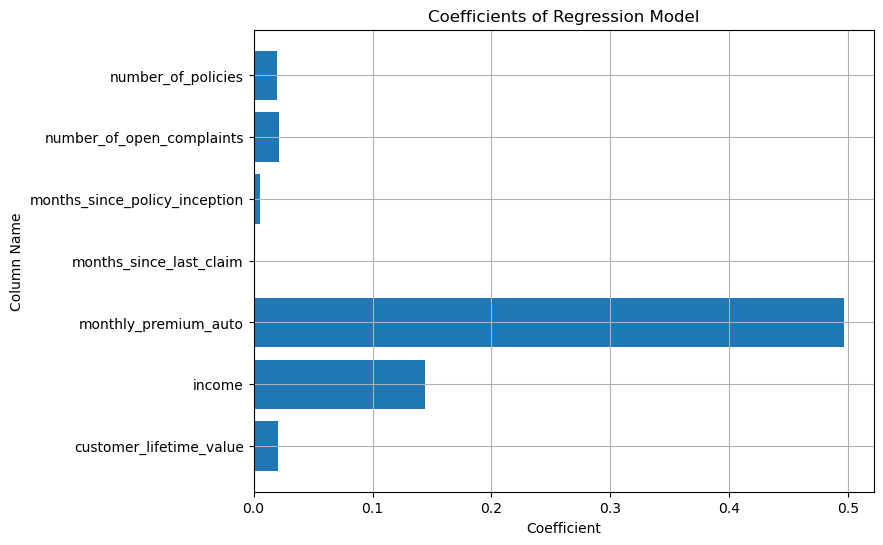

In [589]:
plt.figure(figsize=(8, 6))
plt.barh(feature_1['Column Names'], feature_1['Coefficients'])
plt.xlabel('Coefficient')
plt.ylabel('Column Name')
plt.title('Coefficients of Regression Model')
plt.grid(True)
plt.show()

## - Encoding the categorical variables

### 1. Creating Dummy Variables for the Nominal Columns

In [590]:
cat.columns

Index(['region', 'response', 'coverage', 'education', 'month',
       'employment_status', 'gender', 'location_code', 'marital_status',
       'policy_type', 'policy', 'renew_offer_type', 'sales_channel',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

In [591]:
cat = pd.get_dummies(cat,columns=["region","response","month","employment_status","gender","location_code",
                                  "marital_status","policy_type","sales_channel","vehicle_class"], dtype=int)

In [ ]:
# location_code should be ordinal since it has an order. Ordinal is not related to importance.
# so, policy type is also nominal.

### 2. Ordinal Encoding for Ordinal Columns

In [592]:
from sklearn.preprocessing import LabelEncoder

In [593]:
le = LabelEncoder()

le.fit(["high school or below","college","bachelor","master","doctor"])
cat["education"]= le.transform(cat["education"])

le.fit(["basic","extended","premium"])
cat["coverage"]= le.transform(cat["coverage"])

le.fit(['personal l1','personal l2','personal l3','corporate l1','corporate l2',
        'corporate l3','special l1','special l2','special l3'])
cat["policy"]= le.transform(cat["policy"])


le.fit(['offer1','offer2','offer3','offer4'])
cat['renew_offer_type']= le.transform(cat['renew_offer_type'])

le.fit(["small","medsize","large"])
cat["vehicle_size"]= le.transform(cat["vehicle_size"])

In [594]:
cat

,coverage,education,policy,renew_offer_type,vehicle_size,region_central,region_east,region_north west,region_west region,response_no,...,sales_channel_agent,sales_channel_branch,sales_channel_call center,sales_channel_web,vehicle_class_four-door car,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car
0,0,1,2,2,1,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,0,1,5,3,1,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
2,0,0,5,2,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,1,1,2,1,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,2,0,4,0,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,2,0,3,2,1,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
10685,0,1,5,1,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
10686,1,0,2,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
10687,2,1,3,0,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0


In [595]:
num_1

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
0,4809,48029,61,7,52,0,9
1,2228,92260,64,3,26,0,1
2,14947,22139,100,34,31,0,2
3,22332,49078,97,10,3,0,2
4,9025,23675,117,33,31,0,7
...,...,...,...,...,...,...,...
10684,15563,61541,253,12,40,0,7
10685,5259,61146,65,7,68,0,6
10686,23893,39837,201,11,63,0,2
10687,11971,64195,158,0,27,4,6


### Concating the encoded categorical with the numerical variables

In [596]:
new_df = pd.concat([num_1,cat],axis=1)

### Splitting our dataframe into test and train

In [597]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [598]:
X = np.array(new_df)
y = np.array(num["total_claim_amount"]).reshape(-1,1)

In [599]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

In [600]:
X_train

array([[ 5908, 86277,    74, ...,     0,     0,     0],
       [ 2397, 22283,    65, ...,     0,     0,     0],
       [ 5296, 96510,    73, ...,     0,     0,     0],
       ...,
       [ 6945, 15850,    61, ...,     0,     0,     1],
       [ 8718, 89096,   111, ...,     0,     1,     0],
       [ 4196, 78114,    64, ...,     0,     0,     0]], dtype=int64)

## Splitting each of the resulting X_train and X_test into X_train_cat, X_train_num, X_test_cat, X_test_num in order to perform power transformation only to numerical variables.

In [601]:
X_train_num = X_train[:,:7]

In [602]:
X_train_cat = X_train[:,7:]

In [603]:
X_test_num = X_test[:,:7]

In [604]:
X_test_cat = X_test[:,7:]

In [605]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train_num)
X_train_num_transformed = pt.transform(X_train_num)
X_test_num_transformed = pt.transform(X_test_num)

## 1. Concating the X_train_num_transformed back with the X_train_cat
## 2. Conating the X_test_num_transformed back with the X_test_cat

In [606]:
X_final = pd.concat([pd.DataFrame(X_train_num_transformed),pd.DataFrame(X_train_cat)],axis=1,ignore_index=True)

In [607]:
X_final

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0.018679,1.294576,-0.505333,0.496117,-0.456447,-0.513102,0.515658,0,3,4,...,1,0,0,0,1,0,0,0,0,0
1,-1.690739,-1.255218,-1.172773,0.238235,1.466368,-0.513102,-1.141608,0,3,3,...,0,1,0,0,1,0,0,0,0,0
2,-0.160695,1.603538,-0.569592,1.518133,-0.057832,-0.513102,0.515658,0,4,5,...,0,1,0,0,1,0,0,0,0,0
3,1.404761,-0.778772,-0.926127,0.964263,-1.298909,-0.513102,-0.060563,0,1,5,...,1,0,0,0,0,0,0,0,0,1
4,0.119116,-0.149345,-0.109354,0.658427,-0.307800,-0.513102,1.568339,1,0,3,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,-1.619385,-0.047787,-1.449011,-1.457712,0.181359,-0.513102,-1.141608,0,1,2,...,0,0,1,0,0,0,0,0,0,1
7478,0.694795,0.966757,1.014336,-0.242617,-0.057832,-0.513102,0.515658,2,3,5,...,0,0,1,0,1,0,0,0,0,0
7479,0.271539,-1.648966,-1.548537,1.179911,-1.250888,-0.513102,-0.060563,0,3,2,...,0,0,1,0,0,0,0,0,0,1
7480,0.603458,1.381259,0.925219,-1.670147,0.147773,-0.513102,0.515658,0,3,3,...,0,1,0,0,0,0,0,0,1,0


In [608]:
X_final_test = pd.concat([pd.DataFrame(X_test_num_transformed),pd.DataFrame(X_test_cat)],axis=1,ignore_index=True)

In [609]:
X_final_test

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-1.440645,0.417070,-1.005335,0.889916,-1.347908,-0.513102,-1.141608,0,1,5,...,0,0,0,1,1,0,0,0,0,0
1,0.871671,1.435300,1.392821,0.412224,-0.649424,2.013516,0.515658,1,0,5,...,0,0,1,0,0,0,0,0,1,0
2,0.686969,1.471986,1.240823,-0.242617,1.265808,-0.513102,0.515658,1,4,7,...,0,0,1,0,0,0,0,0,1,0
3,0.705911,-0.671014,-0.160731,0.814217,-0.532607,-0.513102,-0.060563,1,0,5,...,0,1,0,0,1,0,0,0,0,0
4,0.798651,-1.632648,1.420003,-0.697863,-1.669637,-0.513102,1.455257,1,0,3,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3202,-1.967406,1.591126,-1.449011,-0.242617,-0.023051,-0.513102,-1.141608,0,1,5,...,0,0,1,0,0,0,0,0,0,1
3203,1.982069,-0.591620,1.223971,0.496117,-1.397983,-0.513102,-0.060563,1,4,3,...,0,1,0,0,0,0,0,0,1,0
3204,1.192192,-1.627124,1.825809,0.737085,1.060640,-0.513102,1.568339,2,4,5,...,0,0,0,1,0,0,0,0,1,0
3205,-0.263327,1.295443,-1.449011,-1.670147,1.634940,-0.513102,1.128565,0,0,5,...,0,0,1,0,1,0,0,0,0,0


## Power transforming our target variable (y)

In [610]:
pt.fit(y_train)
y_train_transformed = pt.transform(y_train)
y_test_transformed = pt.transform(y_test)

## Performing Linear Regression

In [611]:
lm = LinearRegression()

model = lm.fit(X_final,y_train_transformed)

In [612]:
y_pred = model.predict(X_final_test)

## Comparing

In [613]:
compare = pd.DataFrame({'y_test':list(y_test_transformed) ,'y_pred': list(y_pred)})
compare

,y_test,y_pred
0,[-0.24396624958434066],[-0.6899490356445312]
1,[0.26434240768752915],[0.30352020263671875]
2,[-2.217679240628924],[-0.6028213500976562]
3,[-1.3251063471108266],[-1.474151611328125]
4,[1.7008351797377181],[1.1737213134765625]
...,...,...
3202,[0.22065479805990468],[0.23055267333984375]
3203,[0.2409017326320982],[0.5340042114257812]
3204,[2.2392343647745285],[1.1418533325195312]
3205,[-1.5646410368808357],[-2.0223770141601562]


## Plotting

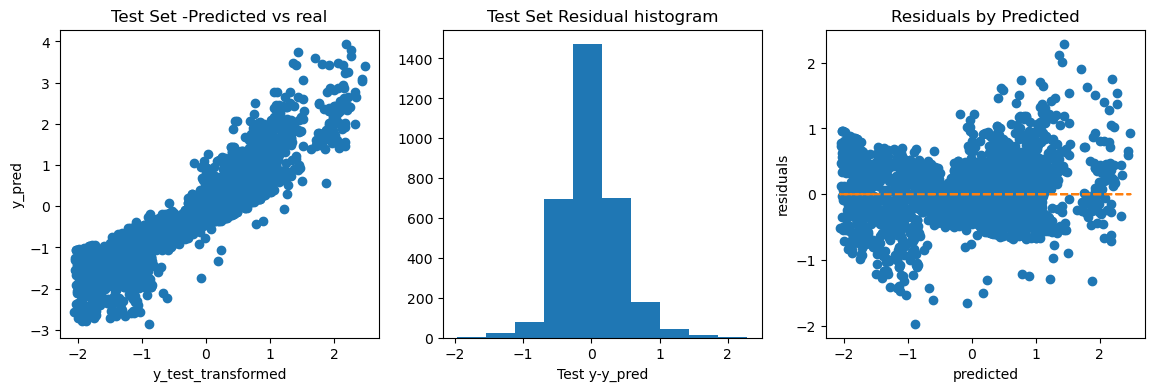

In [614]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test_transformed, 'o')
ax[0].set_xlabel("y_test_transformed")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscedasticity
# Does it resemble a normal distribution?
ax[1].hist(y_test_transformed - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test_transformed - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

## Calculating R2

In [615]:
R2 = r2(y_test_transformed,y_pred)
print("R2 =",R2)

R2 = 0.8293774500922124


## Removing outliers from our numerical data frame

In [616]:
def remove_outlier(df):
    for i in df.columns:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        iqr = q3-q1
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df.loc[(df[i] > fence_low) & (df[i] < fence_high)]
    return df_out


In [617]:
num_new = remove_outlier(num)
num_new

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,4809,48029,61,7,52,0,9,292
1,2228,92260,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
3,22332,49078,97,10,3,0,2,484
4,9025,23675,117,33,31,0,7,707
...,...,...,...,...,...,...,...,...
10682,2771,59855,74,30,82,4,1,355
10683,19228,58280,187,14,32,0,2,897
10685,5259,61146,65,7,68,0,6,273
10686,23893,39837,201,11,63,0,2,381


## Concating the numerical with the categorical variables for our final X

In [618]:
X = pd.concat([num_new,cat],axis=1)

In [619]:
X

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,coverage,education,...,sales_channel_agent,sales_channel_branch,sales_channel_call center,sales_channel_web,vehicle_class_four-door car,vehicle_class_luxury car,vehicle_class_luxury suv,vehicle_class_sports car,vehicle_class_suv,vehicle_class_two-door car
0,4809.0,48029.0,61.0,7.0,52.0,0.0,9.0,292.0,0,1,...,1,0,0,0,1,0,0,0,0,0
1,2228.0,92260.0,64.0,3.0,26.0,0.0,1.0,744.0,0,1,...,0,0,1,0,1,0,0,0,0,0
2,14947.0,22139.0,100.0,34.0,31.0,0.0,2.0,480.0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,22332.0,49078.0,97.0,10.0,3.0,0.0,2.0,484.0,1,1,...,0,1,0,0,1,0,0,0,0,0
4,9025.0,23675.0,117.0,33.0,31.0,0.0,7.0,707.0,2,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,...,0,0,1,0,0,0,0,0,1,0
10659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,...,0,0,0,1,1,0,0,0,0,0
10679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,...,1,0,0,0,0,0,1,0,0,0
10684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,...,0,0,0,1,0,1,0,0,0,0


## We ended up with lots of NaN since we did not drop outliers in the categorical columns. So, I will drop NaN's.

In [620]:
X = X.dropna()

## Dropping total claim amount since it is our target variable

In [621]:
y = np.array(X["total_claim_amount"]).reshape(-1,1)

In [622]:
X = np.array(X.drop(columns="total_claim_amount"))

## Splitting our X and Y

In [623]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)

## Splitting our X into num and cat to transform only the numerical ones

In [624]:
X_train_num = X_train[:,:7]

In [625]:
X_train_cat = X_train[:,7:]

In [626]:
X_test_num = X_test[:,:7]

In [627]:
X_test_cat = X_test[:,7:]

## Power transforming only the numerical ones

In [628]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train_num)
X_train_num_transformed = pt.transform(X_train_num)
X_test_num_transformed = pt.transform(X_test_num)

## Concating back

In [629]:
X_finale = pd.concat([pd.DataFrame(X_train_num_transformed),pd.DataFrame(X_train_cat)],axis=1,ignore_index=True)

In [630]:
X_finale

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,-0.032005,0.333489,-0.575573,1.529634,-1.278227,1.904001,0.523051,0.0,3.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.610881,0.547069,-1.435058,1.038086,1.123745,-0.512456,-1.147728,0.0,1.0,4.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.121875,1.609724,-0.188275,-0.056529,-0.219849,-0.512456,-1.147728,1.0,3.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-1.593805,-1.051417,-1.142565,0.810662,-0.671007,-0.512456,-1.147728,0.0,3.0,4.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.691921,-0.554131,1.915263,1.111431,-0.439704,1.998562,-0.057684,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7098,-0.160789,1.337467,-1.236284,1.661778,1.494943,-0.512456,1.140466,0.0,3.0,5.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7099,-0.743517,0.268750,0.553675,-1.678072,-0.219849,-0.512456,-1.147728,1.0,3.0,5.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7100,-0.307153,0.673134,1.218094,-1.290417,-0.710878,-0.512456,-1.147728,2.0,3.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7101,0.596700,-1.016397,1.218094,0.487240,-0.671007,-0.512456,1.583226,2.0,0.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [631]:
X_finale_test = pd.concat([pd.DataFrame(X_test_num_transformed),pd.DataFrame(X_test_cat)],axis=1,ignore_index=True)

In [632]:
X_finale_test 

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.267226,0.783169,-0.723239,1.183649,-2.082339,-0.512456,-0.057684,0.0,1.0,2.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.763320,1.575474,1.197093,-0.845046,0.389841,-0.512456,0.523051,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.594890,-0.841694,0.877139,-1.129546,-0.874832,-0.512456,-1.147728,0.0,1.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.074296,1.437401,-0.965491,0.487240,0.292480,-0.512456,1.326333,0.0,3.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.077705,-0.863174,-0.648113,0.652140,0.193589,2.015017,1.140466,0.0,0.0,6.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,-0.158470,1.606726,-1.236284,-0.982133,1.094521,-0.512456,1.326333,0.0,4.0,4.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3041,0.549179,1.257876,-0.965491,-0.594202,-1.183370,-0.512456,-0.057684,0.0,3.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3042,-0.403930,-1.672252,1.153714,1.596115,-1.047195,-0.512456,-1.147728,2.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3043,-0.703611,-0.323187,0.725603,-1.129546,0.611608,-0.512456,-1.147728,1.0,0.0,4.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Power transforming our target variable (y)

In [633]:
pt.fit(y_train)
y_train_transformed = pt.transform(y_train)
y_test_transformed = pt.transform(y_test)

## Performing Linear Regression

In [634]:
lm = LinearRegression()

model = lm.fit(X_finale,y_train_transformed)

In [635]:
y_pred = model.predict(X_finale_test)

## Compare

In [636]:
compare = pd.DataFrame({'y_test':list(y_test_transformed) ,'y_pred': list(y_pred)})
compare

,y_test,y_pred
0,[-0.14507001055248797],[0.0546875]
1,[0.8276586176789559],[1.28125]
2,[0.5734325907365448],[0.9609375]
3,[0.40875903177679274],[-0.296875]
4,[-0.6792060930058481],[-0.392578125]
...,...,...
3040,[-0.2827770968925073],[-0.525390625]
3041,[-0.2492000952383467],[-0.734375]
3042,[1.0266951010815044],[0.62109375]
3043,[-0.6166632146241412],[-1.138671875]


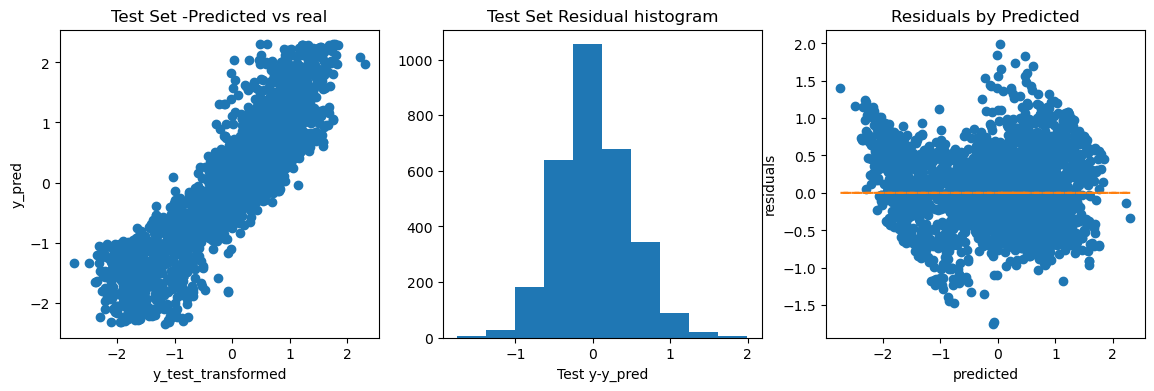

In [637]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test_transformed, 'o')
ax[0].set_xlabel("y_test_transformed")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscedasticity
# Does it resemble a normal distribution?
ax[1].hist(y_test_transformed - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test_transformed - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

## Calculating R2 after removing outliers

In [638]:
R2 = r2(y_test_transformed,y_pred)
print("R2 =",R2)

R2 = 0.7720676445131394


### I think since I dropped NaN's after removing outliers instead of replacing with the mean, the value of R2 I got after removing outliers is less than before.